# Init

In [1]:
%%time

import numpy as np
import pandas as pd

from datetime import datetime, timedelta 

import math

# To plot graphs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib nbagg

# To allow more outputs in Jupyter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Need to parse date with extra function because of the format
mydateparser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S:%f')

# Path to left wrist, right wrist Actigraphy and Polysomnography data
path = "C:\\Users\\sigmu\\Desktop\\dataset\\"
ACG_file = "MECSLEEP01_left_wrist_012870_2013-06-12_11-40-37"

PSG_file = "mecsleep01_psg"

# Read files, name columns, put time stamp into index, skip rows to actual data 
df = pd.read_csv(path + "Aktigrafie\\" + ACG_file + '.csv', names=[
                 'time stamp', 'x axis [g]', 'y axis [g]', 'z axis [g]', 'light level [lux]', 'button [1/0]','temperature [°C]'], 
                  date_parser=mydateparser, index_col='time stamp', skiprows=100)

df_PSG = pd.read_csv(path + "Polysomnografie\\" + PSG_file + '.txt', sep='\t', parse_dates=[2],
                     index_col='Time [hh:mm:ss]', skiprows=17)

# Drop not needed columns
df.drop(columns=['light level [lux]', 'button [1/0]', 'temperature [°C]'], inplace=True, axis=1)
df_PSG.drop(columns=['Position', 'Event', 'Duration[s]'], inplace=True, axis=1)

Wall time: 3min 16s


In [2]:
df

,x axis [g],y axis [g],z axis [g]
time stamp,,,
2015-05-20 18:00:00.500,0.2130,0.1242,-0.9782
2015-05-20 18:00:00.511,0.2248,0.1163,-0.9742
2015-05-20 18:00:00.523,0.2248,0.1124,-0.9703
2015-05-20 18:00:00.535,0.2209,0.1163,-0.9624
2015-05-20 18:00:00.546,0.2406,0.1006,-0.9663
...,...,...,...
2015-05-21 15:31:47.942,-0.8048,0.0022,-0.6824
2015-05-21 15:31:47.953,-0.6865,0.0888,-0.7218
2015-05-21 15:31:47.965,-0.7456,0.1518,-0.5917


## Plot: df 3 axis acceleration

In [3]:
fig0, (ax1, ax2, ax3) = plt.subplots(3, sharex='all', sharey='all')

ax1.plot(df['x axis [g]'])
ax1.grid()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

ax2.plot(df['y axis [g]'])
ax2.grid()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

ax3.plot(df['z axis [g]'])
ax3.grid()
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

<IPython.core.display.Javascript object>

In [4]:
df_PSG

,Sleep Stage
Time [hh:mm:ss],
2020-12-09 23:21:49,W
2020-12-09 23:22:19,W
2020-12-09 23:22:49,W
2020-12-09 23:23:19,N1
2020-12-09 23:23:49,N1
...,...
2020-12-09 06:18:49,W
2020-12-09 06:19:19,W
2020-12-09 06:19:49,W


## Plot: df_PSG

In [5]:
print("PSG start:", df_PSG.index[0].hour, ":", df_PSG.index[0].minute, ":", df_PSG.index[0].second)
print("PSG end:", df_PSG.index[-1].hour, ":", df_PSG.index[-1].minute, ":", df_PSG.index[-1].second)

fig0, (ax1) = plt.subplots()

ax1.plot(df_PSG['Sleep Stage'])
ax1.grid()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

PSG start: 23 : 21 : 49
PSG end: 6 : 20 : 49


<IPython.core.display.Javascript object>

# Cut ACG to match PSG timewise	

In [6]:
%%time
# Find ACG timestamp that matches PSG start & end
df_PSG_len = len(df_PSG.index)-1
df_len = len(df.index)-1

lbstart = df[(df.index.hour == df_PSG.index[0].hour) & (df.index.minute == df_PSG.index[0].minute) & 
   (df.index.second == df_PSG.index[0].second)].index[0]
lbend = df[(df.index.hour == df_PSG.index[df_PSG_len].hour) & (df.index.minute == df_PSG.index[df_PSG_len].minute) & 
   (df.index.second == df_PSG.index[df_PSG_len].second)].index[0]

# Get index of start & end timestamp
idx_start = df.index.get_slice_bound(lbstart, side ='right', kind ='getitem')
idx_end = df.index.get_slice_bound(lbend, side ='right', kind ='getitem')

# Drop everything else and create new df (df didn't work properly), -100 to get headstart
df_drp = df

df_drp = df_drp.drop(df.index[0:(idx_start-100)])
df_drp = df_drp.drop(df.index[(idx_end):(len(df.index))])
#del df

Wall time: 35.7 s


In [7]:
print("PSG length", df_PSG_len)
print("ACG length", df_len)
print(lbstart)
print(lbend)
print(idx_start)
print(idx_end)
print("ACG length cut", len(df_drp))

PSG length 838
ACG length 6643499
2015-05-20 23:21:49.008000
2015-05-21 06:20:49.006000
1655016
3809873
ACG length cut 2154957


## Plot: acc b4 & after cut

In [8]:
fig0, (ax1, ax2) = plt.subplots(2, sharex='all', sharey='all')

ax1.plot(df['x axis [g]'])
ax1.grid()
#ax1.set_ylim(-5, 5)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

ax2.plot(df_drp['x axis [g]'])
ax2.grid()
#ax2.set_ylim(-5, 5)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

<IPython.core.display.Javascript object>

In [9]:
print("PSG start:", df_PSG.index[0].hour, ":", df_PSG.index[0].minute, ":", df_PSG.index[0].second)
print("PSG end:", df_PSG.index[-1].hour, ":", df_PSG.index[-1].minute, ":", df_PSG.index[-1].second)

print("ACG start:", df_drp.index[0].hour, ":", df_drp.index[0].minute, ":", df_drp.index[0].second)
print("ACG end:", df_drp.index[-1].hour, ":", df_drp.index[-1].minute, ":", df_drp.index[-1].second)

df_drp

PSG start: 23 : 21 : 49
PSG end: 6 : 20 : 49
ACG start: 23 : 21 : 47
ACG end: 6 : 20 : 49


,x axis [g],y axis [g],z axis [g]
time stamp,,,
2015-05-20 23:21:47.853,0.1854,0.0848,-0.9939
2015-05-20 23:21:47.865,0.1893,0.0809,-0.9979
2015-05-20 23:21:47.876,0.1893,0.0848,-1.0058
2015-05-20 23:21:47.888,0.1933,0.0730,-0.9979
2015-05-20 23:21:47.900,0.2012,0.0848,-0.9939
...,...,...,...
2015-05-21 06:20:48.960,0.8915,0.4470,-0.2880
2015-05-21 06:20:48.971,0.8955,0.4667,-0.2920
2015-05-21 06:20:48.983,0.9033,0.4746,-0.2998


# 1. branch Resample in 5s epochs

In [10]:
# Resample by 5 second epoch and compute median of x,y,z
## origin... to match start of PSG
df_res = df_drp.resample('5S', origin=df_PSG.index[0]).median().round(decimals=4)

## first value was b4 PSG
df_res.drop(df_res.index[0], inplace=True)

In [11]:
print("PSG start:", df_PSG.index[0].hour, ":", df_PSG.index[0].minute, ":", df_PSG.index[0].second)
print("PSG end:", df_PSG.index[-1].hour, ":", df_PSG.index[-1].minute, ":", df_PSG.index[-1].second)

print("ACG start:", df_res.index[0].hour, ":", df_res.index[0].minute, ":", df_res.index[0].second)
print("ACG end:", df_res.index[-1].hour, ":", df_res.index[-1].minute, ":", df_res.index[-1].second)

df_res

PSG start: 23 : 21 : 49
PSG end: 6 : 20 : 49
ACG start: 23 : 21 : 49
ACG end: 6 : 20 : 49


,x axis [g],y axis [g],z axis [g]
time stamp,,,
2015-05-20 23:21:49,0.1933,0.0809,-0.9900
2015-05-20 23:21:54,0.1933,0.0809,-0.9939
2015-05-20 23:21:59,0.1933,0.0809,-0.9939
2015-05-20 23:22:04,0.1972,0.0730,-0.9939
2015-05-20 23:22:09,0.1933,0.0730,-0.9939
...,...,...,...
2015-05-21 06:20:29,0.4655,0.5376,-0.7179
2015-05-21 06:20:34,0.4418,0.5651,-0.7100
2015-05-21 06:20:39,0.4852,0.5316,-0.7060


## Plot: acc b4 & after - resampled: 5 sec

In [12]:
fig0, (ax2, ax3) = plt.subplots(2, sharex='all', sharey='all')

ax2.plot(df_drp['x axis [g]'])
ax2.grid()
#ax2.set_ylim(-5, 5)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

ax3.plot(df_res['x axis [g]'])
ax3.grid()
#ax3.set_ylim(-5, 5)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

<IPython.core.display.Javascript object>

In [13]:
fig0, (ax1) = plt.subplots()

ax1.plot(df['x axis [g]'], label='původní')
ax1.plot(df_res['x axis [g]'], label='navzorkované', color="Yellow")
ax1.grid()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#ax1.margins(x=-0.41, y=0)
#ax1.set_ylim(-1.1, 1)
ax1.legend(loc="upper left")
ax1.set_ylabel(r'$a_x$ [g]')

#ax2.plot(df_res0['x axis [g]'], label='navzorkované', color="Green")
#ax2.grid()
#ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
##ax2.margins(x=-0.41, y=0)
#ax2.set_ylim(-1.1, 1)
#ax2.legend()
#ax2.set_ylabel(r'$a_x$ [g]')
#ax2.set_xlabel('t [h]')

<IPython.core.display.Javascript object>

Text(0, 0.5, '$a_x$ [g]')

In [14]:
# ax1.get_figure().savefig(path + "Aktigrafie\\" + "Plot_a_x_in1_t_" + ACG_file + '.pdf')

In [15]:
# returns_path_csv = path + "Aktigrafie\\" + "test_" + ACG_file + '.txt'

# df_PSG.to_csv(returns_path_csv)

# Compute angle

In [17]:
def comp_angle(row):
    return math.degrees(math.atan(row['z axis [g]'] / (row['x axis [g]']**2 + row['y axis [g]']**2)))

# Apply func comp_angle
df_res['angle'] = df_res.apply(comp_angle, axis=1).round(decimals=4)

#Average angle per 5 sec epoch
#df_res['angle'] = df_drp.resample('5S').mean().round(decimals=4)?????

# Return absolute difference in angle per column
df_res['abs angle change'] = df_res['angle'].diff().round(decimals=4).abs()

# New column all "W" 
state_5_10_1 = 'State 5s_10,1'
state_5_10_5 = 'State 5s_10,5'

df_res[state_5_10_1] = "W"
df_res[state_5_10_5] = "W"

state_30_10_1 = 'State 30s_10,1'
state_30_10_5 = 'State 30s_10,5'

In [18]:
df_res

,x axis [g],y axis [g],z axis [g],angle,abs angle change,"State 5s_10,1","State 5s_10,5"
time stamp,,,,,,,
2015-05-20 23:21:49,0.1933,0.0809,-0.9900,-87.4604,NaN,W,W
2015-05-20 23:21:54,0.1933,0.0809,-0.9939,-87.4704,0.0100,W,W
2015-05-20 23:21:59,0.1933,0.0809,-0.9939,-87.4704,0.0000,W,W
2015-05-20 23:22:04,0.1972,0.0730,-0.9939,-87.4527,0.0177,W,W
2015-05-20 23:22:09,0.1933,0.0730,-0.9939,-87.5403,0.0876,W,W
...,...,...,...,...,...,...,...
2015-05-21 06:20:29,0.4655,0.5376,-0.7179,-54.8383,1.3528,W,W
2015-05-21 06:20:34,0.4418,0.5651,-0.7100,-54.0698,0.7685,W,W
2015-05-21 06:20:39,0.4852,0.5316,-0.7060,-53.7312,0.3386,W,W


## Plot: 3 ax, angle, abs angle - resampled: 5s

<IPython.core.display.Javascript object>


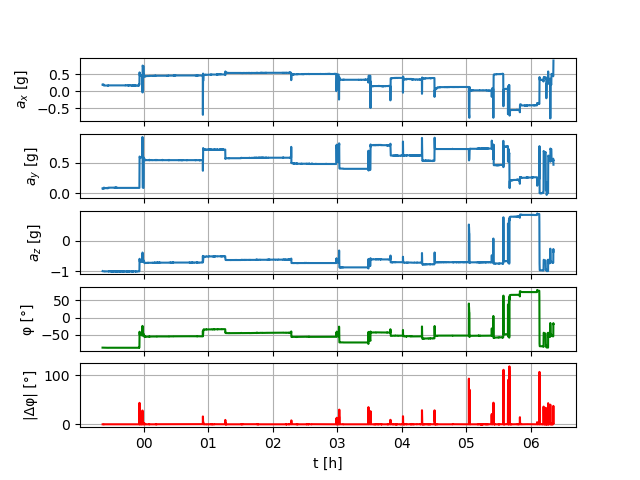

Text(0, 0.5, '$a_x$ [g]')

Text(0, 0.5, '$a_y$ [g]')

Text(0, 0.5, '$a_z$ [g]')

Text(0, 0.5, 'φ [°]')

Text(0, 0.5, '|Δφ| [°]')

Text(0.5, 0, 't [h]')

In [19]:
fig0, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex='all')

ax1.plot(df_res['x axis [g]'], label='ax')
ax1.grid()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#a12.margins(x=-0.41, y=0)
#ax1.set_ylim(-1.1, 1)
#ax1.legend()
ax1.set_ylabel(r'$a_x$ [g]')

ax2.plot(df_res['y axis [g]'], label='ay')
ax2.grid()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#ax2.set_ylim(-1.1, 1)
#ax2.legend()
ax2.set_ylabel(r'$a_y$ [g]')

ax3.plot(df_res['z axis [g]'], label='az')
ax3.grid()
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#ax3.set_ylim(-1.1, 1)
#ax3.legend()
ax3.set_ylabel(r'$a_z$ [g]')

ax4.plot(df_res['angle'], label='úhel', color='Green')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax4.grid()
ax4.set_ylabel('φ [°]')
#ax4.legend()

ax5.plot(df_res['abs angle change'], label='úhel', color='Red')
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax5.grid()
ax5.set_ylabel('|Δφ| [°]')
ax5.set_xlabel('t [h]')
#ax5.legend()


In [20]:
# ax1.get_figure().savefig(path + "Aktigrafie\\" + "Plot_a_x,y,z_angle,abs" + ACG_file + '.pdf')

# Measure inactivity

In [21]:
def inactiv(thr_1st, thr, clmn_name, df):
    counter = 1
    first_S = False
    for index, value in df['abs angle change'].items():
        counter += 1

        # Angle change > 5
        if (value > 5):
            counter = 0
            df.loc[index, clmn_name] = "W"
        # After first sleep - shorter threshold    
        elif (counter > thr_1) & first_S:
            counter += 1
            df.loc[index, clmn_name] = "S"
            SE = index
        # First sleep - longer threshold 
        elif (counter > thr_0):
            counter += 1
            df.loc[index, clmn_name] = "S"
            first_S = True
            # Sleep Onset (start of sleep)
            SO = index
    return

# (10 min)(1 min)
thr_0 = (10 * 60) / 5
thr_1 = (1 * 60) / 5
inactiv(thr_0, thr_1, state_5_10_1, df_res)

# (10 min)(5 min)
thr_1 = (5 * 60) / 5
inactiv(thr_0, thr_1, state_5_10_5, df_res)

In [22]:
df_res

,x axis [g],y axis [g],z axis [g],angle,abs angle change,"State 5s_10,1","State 5s_10,5"
time stamp,,,,,,,
2015-05-20 23:21:49,0.1933,0.0809,-0.9900,-87.4604,NaN,W,W
2015-05-20 23:21:54,0.1933,0.0809,-0.9939,-87.4704,0.0100,W,W
2015-05-20 23:21:59,0.1933,0.0809,-0.9939,-87.4704,0.0000,W,W
2015-05-20 23:22:04,0.1972,0.0730,-0.9939,-87.4527,0.0177,W,W
2015-05-20 23:22:09,0.1933,0.0730,-0.9939,-87.5403,0.0876,W,W
...,...,...,...,...,...,...,...
2015-05-21 06:20:29,0.4655,0.5376,-0.7179,-54.8383,1.3528,S,W
2015-05-21 06:20:34,0.4418,0.5651,-0.7100,-54.0698,0.7685,S,W
2015-05-21 06:20:39,0.4852,0.5316,-0.7060,-53.7312,0.3386,S,W


## Plot: 1 min vs 5 min threshold - resampling: 5s

<IPython.core.display.Javascript object>


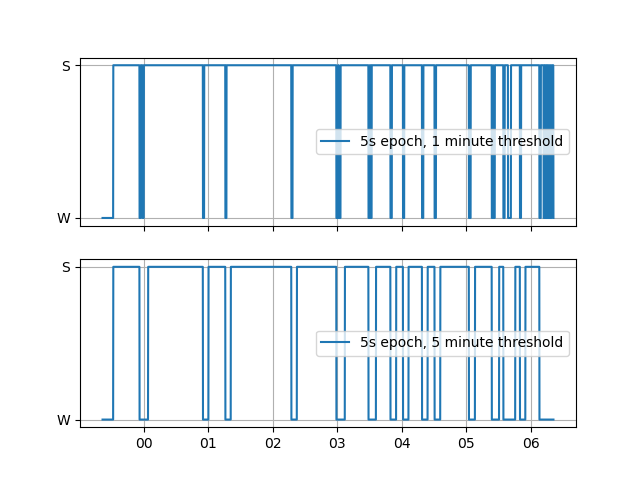

In [23]:
fig0, (ax1, ax2) = plt.subplots(2, sharex='all')#, title='1 min vs 5 min thrs')

ax1.plot(df_res[state_5_10_1], label='5s epoch, 1 minute threshold')
ax1.grid()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax1.legend()

ax2.plot(df_res[state_5_10_5], label='5s epoch, 5 minute threshold')
ax2.grid()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax2.legend()

# Calculate TST 
## - so far not needed (all 'S' are presumed to be TST)

In [24]:
# SO.hour
# SO.minute
#
# SE.hour
# SE.minute

# for i in range (1, len(df_res)):
#    if df_res['State'].iloc[-i] == 'S':
#        SE = df_res.index[-i]
#        break

# SE.hour
# SE.minute

# lbstart = df[(df.index.hour == df_PSG.index[0].hour) & (df.index.minute == df_PSG.index[0].minute) & 
#   (df.index.second == df_PSG.index[0].second)].index[0]

# for i in range (1, len(df_res)):
#    df_res[(df_res.index.hour == SE.hour) & (df_res.index.minute == SE.minute))]
#        print(df_res.index.hour)
#        break
   
# df_res['State'].value_counts()
# #TST = 

# Compare to PSG

In [25]:
# Resample to have same number of columns (30s epochs)
df_res_PSG = df_res.resample('30S', origin=df_PSG.index[0]).interpolate()

# Overwrite State PSG to bi-state 
df_res_PSG['State PSG'] = np.where((df_PSG['Sleep Stage'] == 'N1')|(df_PSG['Sleep Stage'] == 'N2')|
                                 (df_PSG['Sleep Stage'] == 'N3')|(df_PSG['Sleep Stage'] == 'R'), 'S', 'W')

# Create boolean column and compare
match = 'match_' + state_5_10_1
df_res_PSG[match] = np.where(df_res_PSG[state_5_10_1] == df_res_PSG['State PSG'], True, False)
match = 'match_' + state_5_10_5
df_res_PSG[match] = np.where(df_res_PSG[state_5_10_5] == df_res_PSG['State PSG'], True, False)

## Plot: x axis, angle, abs angle - resampling: 5s vs 5s&30s(for PSG)

<IPython.core.display.Javascript object>


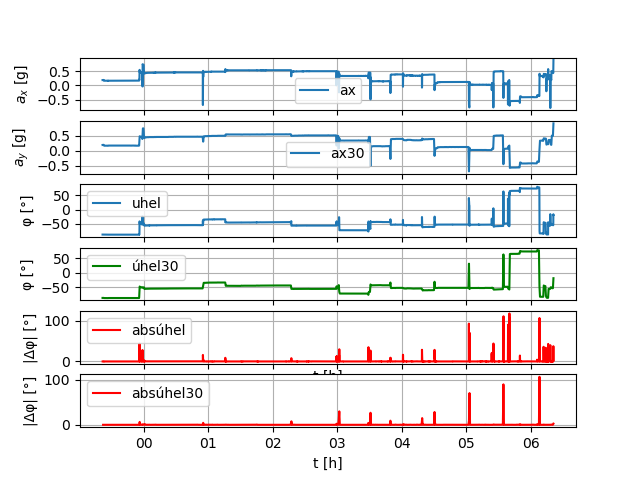

Text(0, 0.5, '$a_x$ [g]')

Text(0, 0.5, '$a_y$ [g]')

Text(0, 0.5, 'φ [°]')

Text(0, 0.5, 'φ [°]')

Text(0, 0.5, '|Δφ| [°]')

Text(0.5, 0, 't [h]')

Text(0, 0.5, '|Δφ| [°]')

Text(0.5, 0, 't [h]')

In [26]:
fig0, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex='all')

ax1.plot(df_res['x axis [g]'], label='ax')
ax1.grid()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#a12.margins(x=-0.41, y=0)
#ax1.set_ylim(-1.1, 1)
ax1.legend()
ax1.set_ylabel(r'$a_x$ [g]')

ax2.plot(df_res_PSG['x axis [g]'], label='ax30')
ax2.grid()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#ax2.set_ylim(-1.1, 1)
ax2.legend()
ax2.set_ylabel(r'$a_y$ [g]')

ax3.plot(df_res['angle'], label='uhel')
ax3.grid()
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#ax3.set_ylim(-1.1, 1)
ax3.legend()
ax3.set_ylabel('φ [°]')

ax4.plot(df_res_PSG['angle'], label='úhel30', color='Green')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax4.grid()
ax4.set_ylabel('φ [°]')
ax4.legend()

ax5.plot(df_res['abs angle change'], label='absúhel', color='Red')
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax5.grid()
ax5.set_ylabel('|Δφ| [°]')
ax5.set_xlabel('t [h]')
ax5.legend()

ax6.plot(df_res_PSG['abs angle change'], label='absúhel30', color='Red')
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax6.grid()
ax6.set_ylabel('|Δφ| [°]')
ax6.set_xlabel('t [h]')
ax6.legend()

In [27]:
df_res
df_res_PSG

,x axis [g],y axis [g],z axis [g],angle,abs angle change,"State 5s_10,1","State 5s_10,5"
time stamp,,,,,,,
2015-05-20 23:21:49,0.1933,0.0809,-0.9900,-87.4604,NaN,W,W
2015-05-20 23:21:54,0.1933,0.0809,-0.9939,-87.4704,0.0100,W,W
2015-05-20 23:21:59,0.1933,0.0809,-0.9939,-87.4704,0.0000,W,W
2015-05-20 23:22:04,0.1972,0.0730,-0.9939,-87.4527,0.0177,W,W
2015-05-20 23:22:09,0.1933,0.0730,-0.9939,-87.5403,0.0876,W,W
...,...,...,...,...,...,...,...
2015-05-21 06:20:29,0.4655,0.5376,-0.7179,-54.8383,1.3528,S,W
2015-05-21 06:20:34,0.4418,0.5651,-0.7100,-54.0698,0.7685,S,W
2015-05-21 06:20:39,0.4852,0.5316,-0.7060,-53.7312,0.3386,S,W


,x axis [g],y axis [g],z axis [g],angle,abs angle change,"State 5s_10,1","State 5s_10,5",State PSG,"match_State 5s_10,1","match_State 5s_10,5"
time stamp,,,,,,,,,,
2015-05-20 23:21:49,0.1933,0.0809,-0.9900,-87.4604,NaN,W,W,W,True,True
2015-05-20 23:22:19,0.1972,0.0730,-0.9939,-87.4527,0.0000,W,W,W,True,True
2015-05-20 23:22:49,0.1972,0.0770,-0.9939,-87.4182,0.0345,W,W,W,True,True
2015-05-20 23:23:19,0.1696,0.0888,-0.9979,-87.8967,0.0000,W,W,S,False,False
2015-05-20 23:23:49,0.1696,0.0848,-0.9979,-87.9365,0.0398,W,W,S,False,False
...,...,...,...,...,...,...,...,...,...,...
2015-05-21 06:18:49,0.1972,0.7226,-0.6824,-50.5745,0.5675,W,W,W,True,True
2015-05-21 06:19:19,0.5010,0.5258,-0.6982,-52.9302,0.1534,S,W,W,False,True
2015-05-21 06:19:49,0.4931,0.5258,-0.7060,-53.6471,0.0000,S,W,W,False,True


(Plot: 1 m vs 5 m threshold - resampling: 5s vs 5s&30s(for PSG))

<IPython.core.display.Javascript object>


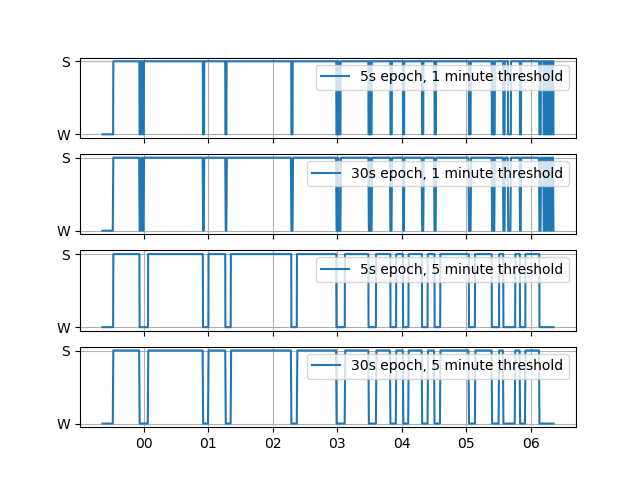

In [28]:
fig0, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex='all')#, title='1 min vs 5 min thrs')

ax1.plot(df_res[state_5_10_1], label='5s epoch, 1 minute threshold')
ax1.grid()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax1.legend()

ax3.plot(df_res[state_5_10_5], label='5s epoch, 5 minute threshold')
ax3.grid()
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax3.legend()

ax2.plot(df_res_PSG[state_5_10_1], label='30s epoch, 1 minute threshold')
ax2.grid()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax2.legend()

ax4.plot(df_res_PSG[state_5_10_5], label='30s epoch, 5 minute threshold')
ax4.grid()
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax4.legend()

# Stats

In [29]:
df_stats = pd.DataFrame(columns=['Participant', 'TST', 'WASO', 'SWR', 'specificity', 'sensitivity', 'accuracy'],
                       index=[state_5_10_1, state_5_10_5, state_30_10_1, state_30_10_5])
    
df_stats['Participant'][0] = PSG_file

def stats(match, state, df):    
    print(state)
    print("========")
    #  Returns relative frequency by dividing all values by the sum of values
    print("Relative frequency: ", df[match].value_counts(normalize='True'))
    print("True count: ", df[match].values.sum())
    print("False count: ", (~df[match]).values.sum())
    print("--------")
    
    # Count Total Sleep Time and Wake After Sleep Onset in minutes... so far all 'S' and 'W' states
    TST = (len(df[df[state]=='S'].index.value_counts()) * 30 ) / 60
    print("TST =", TST)
    df_stats['TST'][state] = TST
    
    WASO = (len(df[df[state]=='W'].index.value_counts()) * 30 ) / 60
    print("WASO =", WASO)
    df_stats['WASO'][state] = WASO
    
    # Sleep Wake Ratio ... the bigger the better sleeper 
    SWR = round(TST / WASO, 4)
    print("SWR =", SWR)
    df_stats['SWR'][state] = SWR
    print("--------")
    
    #sensitivity (actigraphy = sleep when PSG = sleep), 
    #specificity (actigraphy = wake when PSG = wake), 
    #and accuracy (total proportion correct)

    # Put all states where: into an array
    TP = np.where((df[state] == 'W') & (df['State PSG'] == 'W'))
    FP = np.where((df[state] == 'W') & (df['State PSG'] == 'S'))
    TN = np.where((df[state] == 'S') & (df['State PSG'] == 'S'))
    FN = np.where((df[state] == 'S') & (df['State PSG'] == 'W'))

    # Return array size
    TP_cnt = np.size(TP)
    FP_cnt = np.size(FP)
    TN_cnt = np.size(TN)
    FN_cnt = np.size(FN)

    # Calculate sensitivity, specificity and accuracy
    sens = round((TP_cnt / (TP_cnt + FN_cnt) )*100, 4)
    spec = round((TN_cnt / (TN_cnt + FP_cnt) )*100, 4)
    acc = round(((TP_cnt + TN_cnt) / (TP_cnt + TN_cnt + FP_cnt + FN_cnt) )*100, 4)

    print("sens =", sens)
    print("spec =", spec)
    print("acc =", acc)
    print("\n")
    
    # Add to df
    df_stats['Participant'][state] = ACG_file
    df_stats['sensitivity'][state] = sens
    df_stats['specificity'][state] = spec    
    df_stats['accuracy'][state] = acc

print("df_res_PSG")
match = 'match_' + state_5_10_1
stats(match, state_5_10_1, df_res_PSG)

match = 'match_' + state_5_10_5
stats(match, state_5_10_5, df_res_PSG)

df_res_PSG
State 5s_10,1
Relative frequency:  True     0.933254
False    0.066746
Name: match_State 5s_10,1, dtype: float64
True count:  783
False count:  56
--------
TST = 377.0
WASO = 42.5
SWR = 8.8706
--------
sens = 68.3544
spec = 95.9211
acc = 93.3254


State 5s_10,5
Relative frequency:  True     0.810489
False    0.189511
Name: match_State 5s_10,5, dtype: float64
True count:  680
False count:  159
--------
TST = 307.5
WASO = 112.0
SWR = 2.7455
--------
sens = 91.1392
spec = 80.0
acc = 81.0489




# 2. branch Resample in 30s epochs

In [30]:
# Resample by 30 second epoch and compute median of x,y,z
## origin... to match start of PSG
df_res_30 = df_drp.resample('30S', origin=df_PSG.index[0]).median().round(decimals=4)
## first value was off
df_res_30.drop(df_res_30.index[0], inplace=True)

## Plot: acc b4 & after - resampled: 5 & 30 sec

<IPython.core.display.Javascript object>


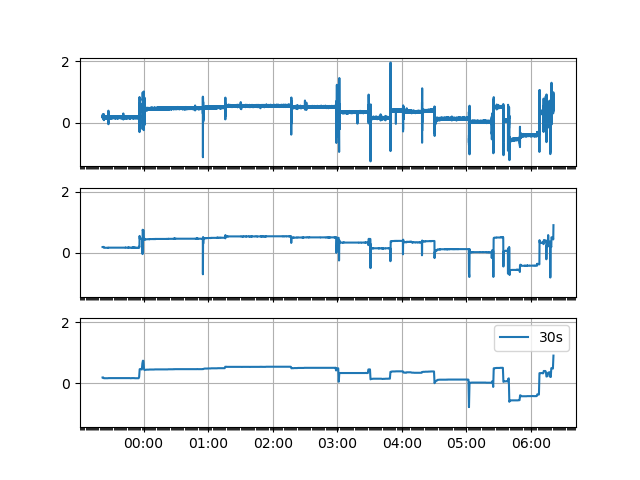

In [31]:
fig0, (ax1, ax2, ax3) = plt.subplots(3, sharex='all', sharey='all')

ax1.plot(df_drp['x axis [g]'])
ax1.grid()
#a12.set_ylim(-5, 5)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

ax2.plot(df_res['x axis [g]'])
ax2.grid()
#a23.set_ylim(-5, 5)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))


ax3.plot(df_res_30['x axis [g]'], label='30s')
ax3.grid()
#ax3.set_ylim(-5, 5)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.xaxis.set_major_locator(mdates.HourLocator())
ax3.xaxis.set_minor_locator(mdates.MinuteLocator())
ax3.legend()

# Compute angle

In [32]:
df_res_30['angle'] = df_res_30.apply(comp_angle, axis=1).round(decimals=4)
df_res_30['abs angle change'] = df_res_30['angle'].diff().round(decimals=4).abs()
df_res_30[state_30_10_1] = "W"
df_res_30[state_30_10_5] = "W"

## Plot: 3 ax, angle, abs angle - resampled: 30s

<IPython.core.display.Javascript object>


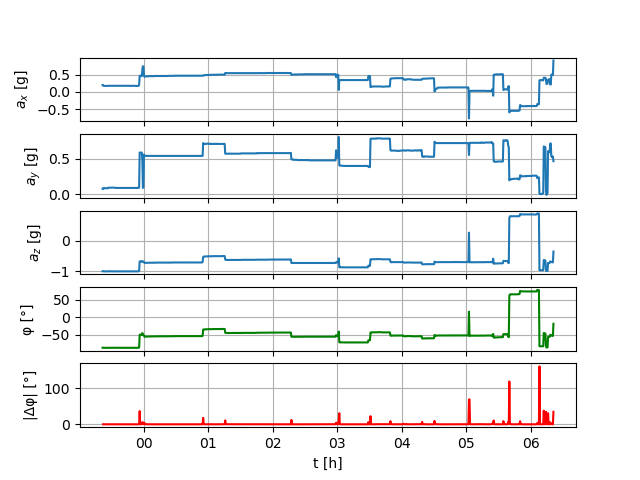

Text(0, 0.5, '$a_x$ [g]')

Text(0, 0.5, '$a_y$ [g]')

Text(0, 0.5, '$a_z$ [g]')

Text(0, 0.5, 'φ [°]')

Text(0, 0.5, '|Δφ| [°]')

Text(0.5, 0, 't [h]')

In [33]:
fig0, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex='all')

ax1.plot(df_res_30['x axis [g]'], label='ax')
ax1.grid()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#a12.margins(x=-0.41, y=0)
#ax1.set_ylim(-1.1, 1)
#ax1.legend()
ax1.set_ylabel(r'$a_x$ [g]')

ax2.plot(df_res_30['y axis [g]'], label='ay')
ax2.grid()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#ax2.set_ylim(-1.1, 1)
#ax2.legend()
ax2.set_ylabel(r'$a_y$ [g]')

ax3.plot(df_res_30['z axis [g]'], label='az')
ax3.grid()
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#ax3.set_ylim(-1.1, 1)
#ax3.legend()
ax3.set_ylabel(r'$a_z$ [g]')

ax4.plot(df_res_30['angle'], label='úhel', color='Green')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax4.grid()
ax4.set_ylabel('φ [°]')
#ax4.legend()

ax5.plot(df_res_30['abs angle change'], label='úhel', color='Red')
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax5.grid()
ax5.set_ylabel('|Δφ| [°]')
ax5.set_xlabel('t [h]')
#ax5.legend()


# Measure inactivity

In [36]:
# Thresholds

# (10 min)(1 min)
thr_0_30 = (10 * 60) / 30
thr_1_30 = (1 * 60) / 30
inactiv(thr_0_30, thr_1_30, state_30_10_1, df_res_30)

# (10 min)(5 min)
thr_1 = (5 * 60) / 30
inactiv(thr_0_30, thr_1_30, state_30_10_5, df_res_30)

## Plot: 1 min vs 5 min threshold - resampling: 30s

<IPython.core.display.Javascript object>


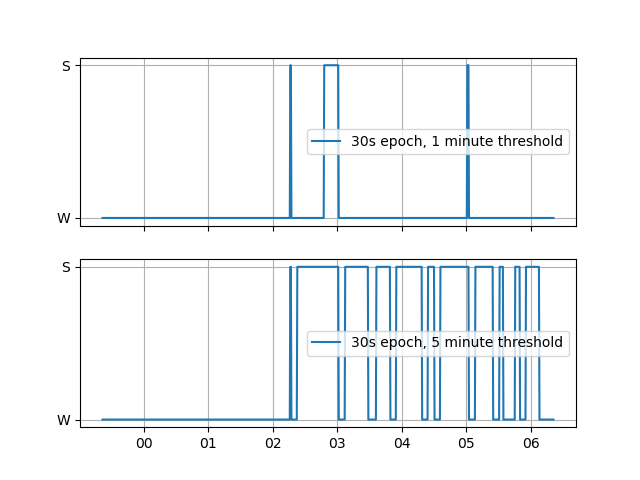

In [35]:
fig0, (ax1, ax2) = plt.subplots(2, sharex='all')#, title='1 min vs 5 min thrs')

ax1.plot(df_res_30[state_30_10_1], label='30s epoch, 1 minute threshold')
ax1.grid()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax1.legend()

ax2.plot(df_res_30[state_30_10_5], label='30s epoch, 5 minute threshold')
ax2.grid()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax2.legend()

# Compare to PSG

In [37]:
# Overwrite State PSG to bi-state 
df_res_30['State PSG'] = np.where((df_PSG['Sleep Stage'] == 'N1')|(df_PSG['Sleep Stage'] == 'N2')|
                                 (df_PSG['Sleep Stage'] == 'N3')|(df_PSG['Sleep Stage'] == 'R'), 'S', 'W')

# Create boolean column and compare
match = 'match_' + state_30_10_1
df_res_30[match] = np.where(df_res_30[state_30_10_1] == df_res_30['State PSG'], True, False)
match = 'match_' + state_30_10_5
df_res_30[match] = np.where(df_res_30[state_30_10_5] == df_res_30['State PSG'], True, False)

<IPython.core.display.Javascript object>


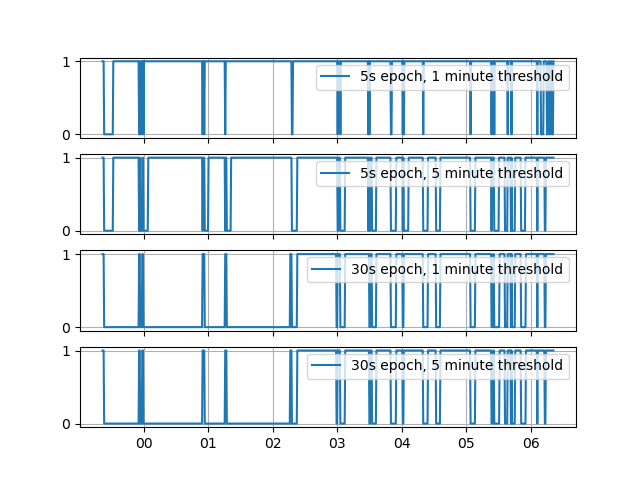

In [38]:
fig0, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex='all')#, title='1 min vs 5 min thrs')

match = 'match_' + state_5_10_1
ax1.plot(df_res_PSG[match], label='5s epoch, 1 minute threshold')
ax1.grid()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax1.legend()

match = 'match_' + state_5_10_5
ax2.plot(df_res_PSG[match], label='5s epoch, 5 minute threshold')
ax2.grid()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax2.legend()

match = 'match_' + state_30_10_1
ax3.plot(df_res_30[match], label='30s epoch, 1 minute threshold')
ax3.grid()
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax3.legend()

match = 'match_' + state_30_10_5
ax4.plot(df_res_30[match], label='30s epoch, 5 minute threshold')
ax4.grid()
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax4.legend()

# Stats

In [40]:
print("df_res_30")
match = 'match_' + state_30_10_1
stats(match, state_30_10_1, df_res_30)

match = 'match_' + state_30_10_5
stats(match, state_30_10_5, df_res_30)

df_res_30
State 30s_10,1
Relative frequency:  False    0.525626
True     0.474374
Name: match_State 30s_10,1, dtype: float64
True count:  398
False count:  441
--------
TST = 167.5
WASO = 252.0
SWR = 0.6647
--------
sens = 89.8734
spec = 43.0263
acc = 47.4374


State 30s_10,5
Relative frequency:  False    0.525626
True     0.474374
Name: match_State 30s_10,5, dtype: float64
True count:  398
False count:  441
--------
TST = 167.5
WASO = 252.0
SWR = 0.6647
--------
sens = 89.8734
spec = 43.0263
acc = 47.4374




In [41]:
df_stats

,Participant,TST,WASO,SWR,specificity,sensitivity,accuracy
"State 5s_10,1",MECSLEEP60_right_wrist_018141_2015-05-21_15-32-02,377,42.5,8.8706,95.9211,68.3544,93.3254
"State 5s_10,5",MECSLEEP60_right_wrist_018141_2015-05-21_15-32-02,307.5,112,2.7455,80,91.1392,81.0489
"State 30s_10,1",MECSLEEP60_right_wrist_018141_2015-05-21_15-32-02,167.5,252,0.6647,43.0263,89.8734,47.4374
"State 30s_10,5",MECSLEEP60_right_wrist_018141_2015-05-21_15-32-02,167.5,252,0.6647,43.0263,89.8734,47.4374


# Export

In [42]:
returns_path_csv = path + "Aktigrafie\\" + "Result_5s_" + ACG_file + '.csv'
_30_returns_path_csv = path + "Aktigrafie\\" + "Result_30s_" + ACG_file + '.csv'

df_res_PSG.to_csv(returns_path_csv)
df_res_30.to_csv(_30_returns_path_csv)

In [44]:
returns_path_csv = path + "Aktigrafie\\" + "Stats" + '.csv'
with open(returns_path_csv, 'a') as f:
             (df_stats).to_csv(f)#, header=False)